In [51]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
%matplotlib inline

import plotly.offline as py


py.init_notebook_mode(connected=True)
#py.renderers.default = "notebook"


import plotly.graph_objs as go
import plotly.tools as tls

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

import csv

    
def double_bar_chart(chart_title, ds1_name, data_series_1, ds2_name, data_series_2):

    
    ct = f"{chart_title} (n={data_series_1.sum()+data_series_2.sum()})"
    
    # Create the figure with stacked bars
    fig = go.Figure(data=[
        go.Bar(name=ds1_name, x=data_series_1.index, y=data_series_1.values),
        go.Bar(name=ds2_name, x=data_series_2.index, y=data_series_2.values)
    ])


    # Update the layout to stack the bars
    fig.update_layout(
        barmode='stack',
        title=ct,
        plot_bgcolor="#FFFFFF",
        showlegend=True,
        xaxis={'categoryorder':'total descending'})

    fig.update_layout(width=700, height=500, bargap=0.05)
    
    # Show the plot
    fig.show()
    

In [52]:
FILENAME = "raw-data-102624.xlsx"

raw_df = pd.read_excel(FILENAME, engine="openpyxl")

#drop columns we don't care about
raw_df.drop (columns=['#', "Response Type", "Start Date (UTC)", "Stage Date (UTC)", "Submit Date (UTC)", "Network ID", "Tags"], inplace=True)


#read questions from separate file

questions = { }
with open('questions.csv') as f:
    reader = csv.reader(f, skipinitialspace=True)
    questions = dict(reader)


#rename columns

raw_df.rename( columns=
              {
                questions['Q1'] : 'Q1',
                questions['Q2'] : 'Q2',
                'Other' : 'Q2Other',
                'How many staff does your organization employ?': 'Q3', 
                'What is your organization’s annual revenue?' : 'Q4',
                'How many years has your organization been using container technology?' : 'Q5',
                'How many years has your organization been using CI/CD ?' : 'Q6',
                'How many years has your organization been using GitOps?' : 'Q7',
                'What is your current role?' : 'Q8',
                'Other.1' : 'Q8Other',
                questions['Q9'] : 'Q9',
                questions['Q10'] : 'Q10',
                questions['Q11'] : 'Q11',
                questions['Q12.A1'] : 'Q12.A1',
                questions['Q12.A2'] : 'Q12.A2',
                questions['Q12.A3'] : 'Q12.A3',
                questions['Q12.A4'] : 'Q12.A4',
                questions['Q12.A5'] : 'Q12.A5',
                questions['Q12.A6'] : 'Q12.A6',
                questions['Q12.A7'] : 'Q12.A7',
                questions['Q12.A8'] : 'Q12.A8',
                questions['Q16'] : 'Q16',
                questions['Q17'] : 'Q17'
              },
              inplace=True)


/Users/richsharples/Library/Python/3.9/lib/python/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning:

Workbook contains no default style, apply openpyxl's default



In [53]:
# Q1 - home or work ?
#

temp_series = raw_df['Q1'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series)))


trace = go.Pie(labels=labels, values=sizes)
layout = go.Layout(
    title='Home vs Work'
)
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="home-work")


In [54]:
# split into two data sets depending on Home or Work usage

home = "At home"
work = "At work"

home_df = raw_df.query("`Q1` == @home").copy()
work_df = raw_df.query("`Q1` == @work").copy()

# ignore category data less than this threshold
THRESHOLD = 4 

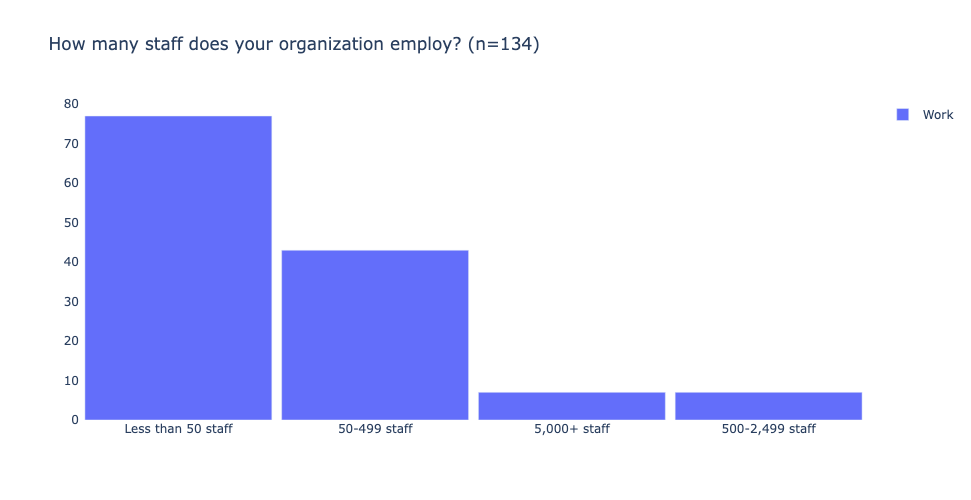

In [67]:
#
# questions 2 - 'What industry segment does your organization most closely align with?'
#
# Not interest in Home users 

# Anything interesting in Other ?
#value_counts = work_df['Q2Other'].value_counts()
#print (value_counts)



double_bar_chart(questions['Q3'], 
                 "Work", work_df['Q3'].value_counts()[lambda x: x > THRESHOLD], 
                 "Home", home_df['Q3'].value_counts()[lambda x: x > THRESHOLD])



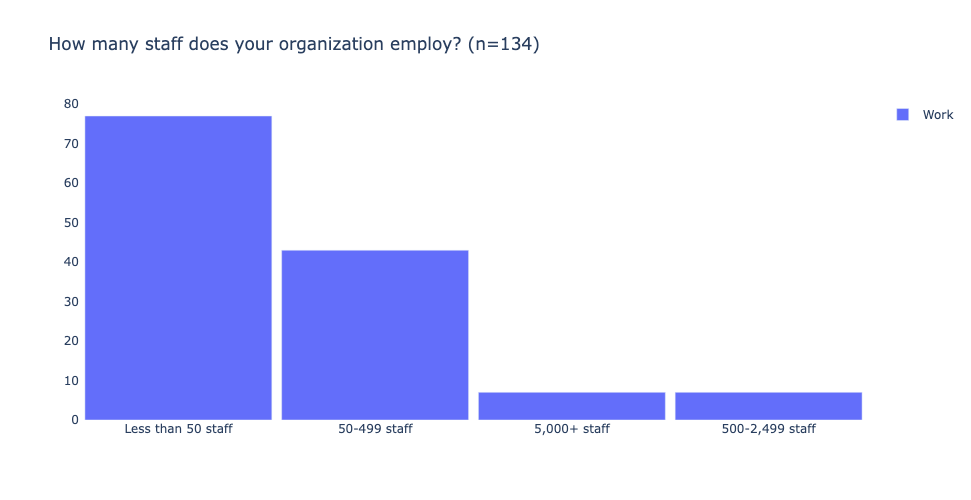

In [66]:
#
# questions 4 - 'How many staff does your organization employ?'
#


double_bar_chart(questions['Q3'], 
                 "Work", work_df['Q3'].value_counts()[lambda x: x > THRESHOLD], 
                 "Home", home_df['Q3'].value_counts()[lambda x: x > THRESHOLD])


In [65]:
#
# questions 4 - 'What is your organization’s annual revenue?' 
#

#drop low count categories, draw bar-chart

double_bar_chart(questions['Q4'], 
                 "Work", work_df['Q4'].value_counts()[lambda x: x > THRESHOLD], 
                 "Home", home_df['Q4'].value_counts()[lambda x: x > THRESHOLD])

In [58]:
#
# questions 5 - How many years has your organization been using container technology?

double_bar_chart(questions['Q5'], 
                 "Work", work_df['Q5'].value_counts()[lambda x: x > 0], 
                 "Home", home_df['Q5'].value_counts()[lambda x: x > 0])
#

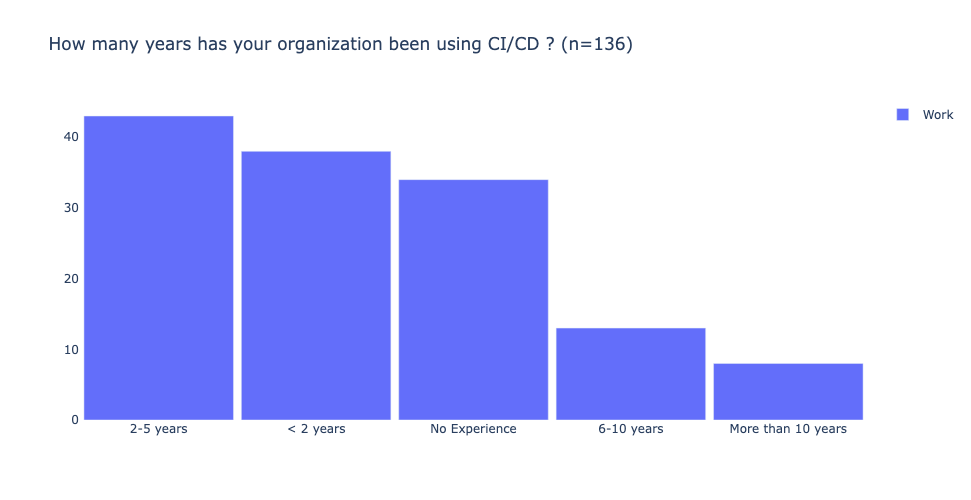

In [59]:
#
# questions 6 - How many years has your organization been using CI/CD ?
#

double_bar_chart(questions['Q6'], 
                 "Work", work_df['Q6'].value_counts()[lambda x: x > 0], 
                 "Home", home_df['Q6'].value_counts()[lambda x: x > 0])
#

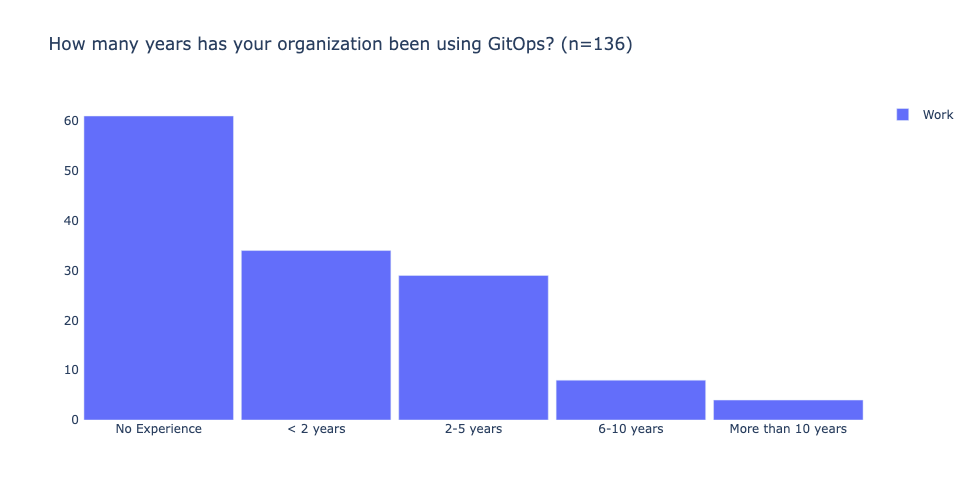

In [60]:
#
# questions 7 - How many years has your organization been using GitOps?
#
double_bar_chart(questions['Q7'], 
                 "Work", work_df['Q7'].value_counts()[lambda x: x > 0], 
                 "Home", home_df['Q7'].value_counts()[lambda x: x > 0])


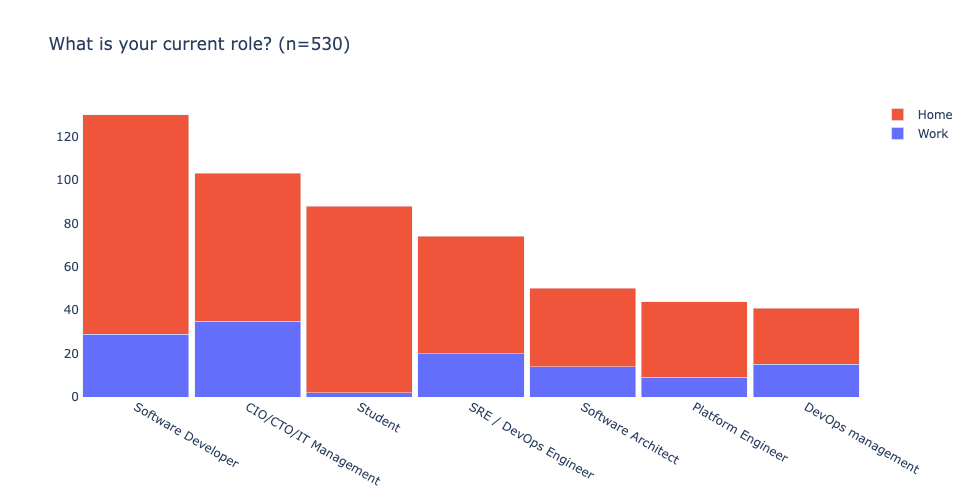

In [61]:
#
# questions 8 - 'What is your current role?'
#

# Anything interesting in Other ?

# value_counts = work_df['Q8Other'].value_counts()
# print (value_counts)

# value_counts = home_df['Q8Other'].value_counts()
# print (value_counts)


double_bar_chart(questions['Q8'], 
                 "Work", work_df['Q8'].value_counts()[lambda x: x > 0], 
                 "Home", home_df['Q8'].value_counts()[lambda x: x > 0])



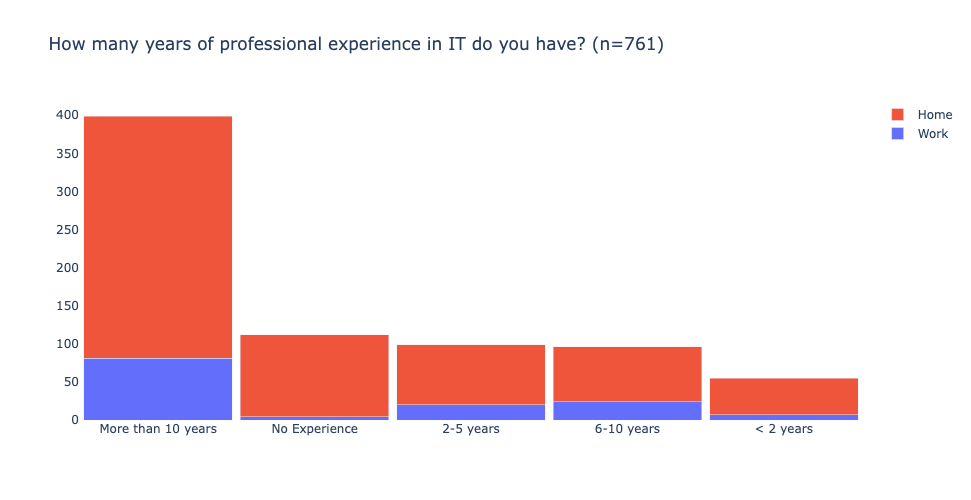

In [62]:
#
# questions 9 - HHow many years of professional experience in IT do you have?
#
double_bar_chart(questions['Q9'], 
                 "Work", work_df['Q9'].value_counts()[lambda x: x > 0], 
                 "Home", home_df['Q9'].value_counts()[lambda x: x > 0])


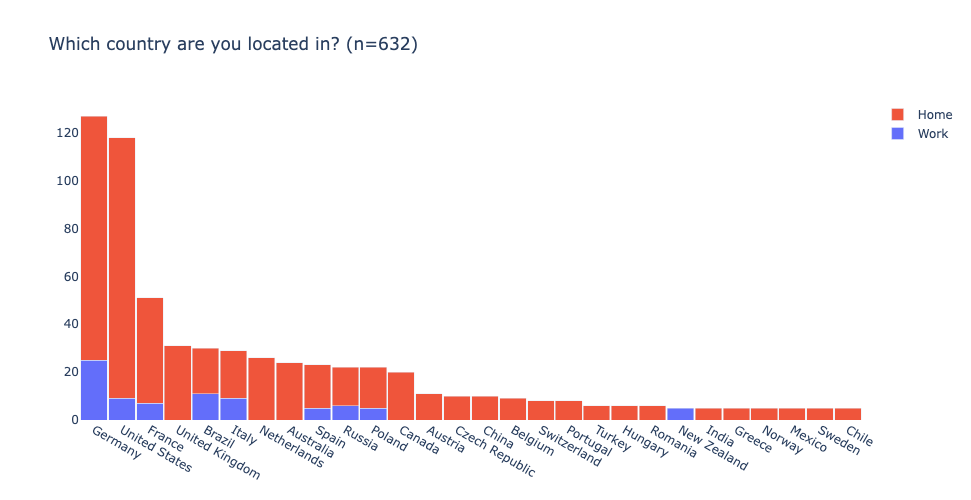

In [63]:
#
# questions 10 - Which country are you located in?
#
double_bar_chart(questions['Q10'], 
                 "Work", work_df['Q10'].value_counts()[lambda x: x > THRESHOLD], 
                 "Home", home_df['Q10'].value_counts()[lambda x: x > THRESHOLD])

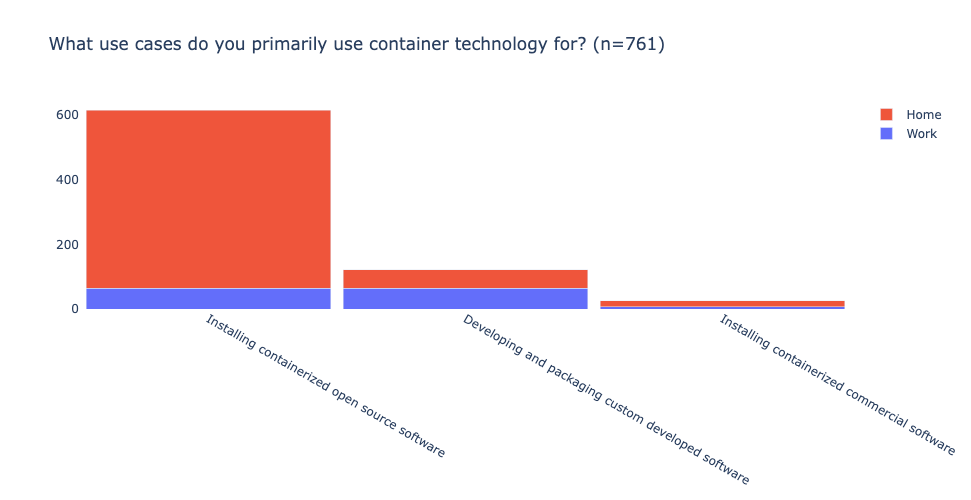

In [64]:
#
# questions 11 - What use cases do you primarily use container technology for?
#
double_bar_chart(questions['Q11'], 
                 "Work", work_df['Q11'].value_counts()[lambda x: x > 0], 
                 "Home", home_df['Q11'].value_counts()[lambda x: x > 0])